# 1 Fetch Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X,y = mnist['data'],mnist['target']
y = y.astype(np.uint8) #converting string to integers
X = X.values

# 2 Exploring the Data

In [20]:
import matplotlib as mpl

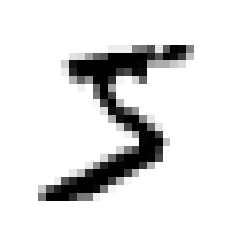

In [22]:
some_digit_image = X[0].reshape(28,28)
plt.imshow(
    some_digit_image, 
    cmap=mpl.cm.binary,
    interpolation='nearest'
)
plt.axis('off')
plt.show()

# 3 Splitting Data

In [32]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]

# 4 Model Building

### 4.1 Binary Classifier

Simplifying to train a '5 detector'

In [38]:
from sklearn.linear_model import SGDClassifier

In [39]:
y_train_5 = y_train==5
y_test_5 = y_test==5

Training the Classifier

In [40]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [54]:
sgd_clf.predict([X[1]])

array([False])

### 4.2 Performance Measures

Measuring Accuracy using Custom Cross Validation

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


Measuring Accuracy using sklearn's cross_val_score

In [59]:
from sklearn.model_selection import cross_val_score

In [60]:
cross_val_score(
    sgd_clf,
    X_train, 
    y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.95035, 0.96035, 0.9604 ])

The accuracies look good, they are above 95%. However I will look at a very simple classifier first

In [61]:
from sklearn.base import BaseEstimator

In [62]:
class Never5Classifier(BaseEstimator):

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)



In [63]:
never5_clf = Never5Classifier()
cross_val_score(
    never5_clf,
    X_train, 
    y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.91125, 0.90855, 0.90915])

The accuracy is above 90% and that is because about 10% of the images are 5s, so the classifier is guessing that it is not a 5 every time and thus it is correct 90% of the time

#### 4.2.1 Confusion Matrix

In [82]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [74]:
y_train_pred = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
)

In [78]:
confusion_matrix(
    y_train_5,
    y_train_pred
)

array([[53892,   687],
       [ 1891,  3530]])

In [80]:
precision_score(
    y_train_5,
    y_train_pred
)

0.8370879772350012

In [81]:
recall_score(
    y_train_5,
    y_train_pred
)

0.6511713705958311

In [83]:
f1_score(
    y_train_5,
    y_train_pred
)

0.7325171197343846

#### 4.2.2 Precision and Recall Tradeoff

I am trying to figure out how to manipulate the precision and recall

In [84]:
y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method='decision_function'
)

In [85]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [86]:
from sklearn.metrics import precision_recall_curve

In [87]:
precision, recalls, thresholds = precision_recall_curve(
    y_train_5,
    y_scores
)

In [89]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

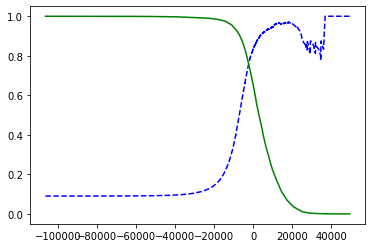

In [90]:
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

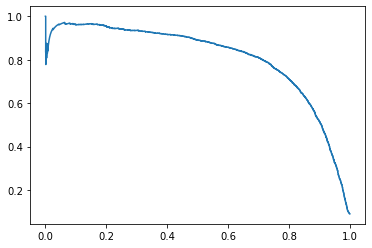

In [91]:
plt.plot(recalls, precision)
plt.show()